/home/vishwa/anaconda3/envs/eeg_proj/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~4.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/home/vishwa/anaconda3/envs/eeg_proj/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~4.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/home/vishwa/anaconda3/envs/eeg_proj/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~4.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/home/vishwa/anaconda3/envs/eeg_proj/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~

Shapes -> Source: (288, 22, 1001)  Target: (288, 22, 1001)
No data for one of the classes in target training split. Skipping CSP baseline.
TKL-based approach test accuracy: 84.03%
Baseline CSP test accuracy:       0.00%


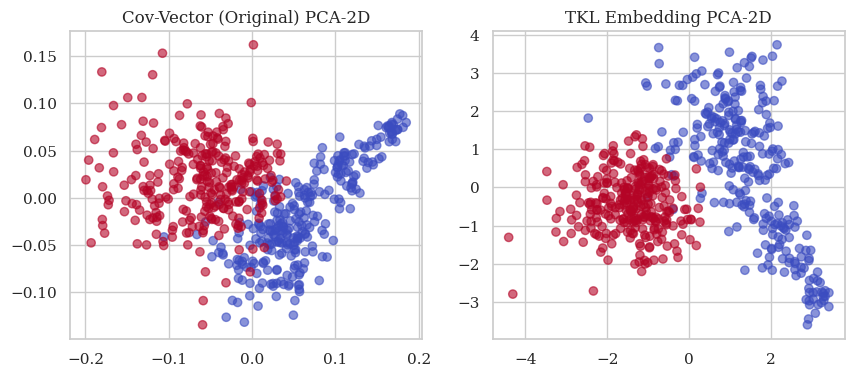

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from moabb.datasets import BNCI2014_001
from moabb.paradigms import LeftRightImagery
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy.linalg import eigh

###############################################################################
# This code shows a transfer-kernel-based motor imagery classification,
# inspired by the TKCSP approach in [1]. It includes a check to prevent
# IndexError when one of the classes has no samples in a train split.

###############################################################################
# 1) Load motor imagery data from BNCI2014_001 using MOABB
#    We pick subject 1 as target and subject 2 as source for a quick demonstration
#    (the user should adjust subject_list or the split for practical usage).

dataset = BNCI2014_001()
subject_list = [1, 2]  # subject 1 -> target, subject 2 -> source
dataset.subject_list = subject_list

paradigm = LeftRightImagery()
X_all, labels_all, meta = paradigm.get_data(dataset=dataset)

X_source = X_all[meta['subject'] == subject_list[1]]
y_source = labels_all[meta['subject'] == subject_list[1]]
X_target = X_all[meta['subject'] == subject_list[0]]
y_target = labels_all[meta['subject'] == subject_list[0]]

print("Shapes -> Source:", X_source.shape, " Target:", X_target.shape)

###############################################################################
# 2) Define helper functions

def compute_covariance(trial):
    """
    Compute normalized covariance for one EEG trial: shape (n_channels, n_time).
    """
    c = np.dot(trial, trial.T)
    # Tiny offset in case of singularities
    c += 1e-15 * np.eye(c.shape[0])
    trc = np.trace(c)
    if trc <= 1e-15:
        trc = 1e-15
    c /= trc
    return c

def compute_csp_filters(cov_class_1, cov_class_2):
    """
    Compute CSP projection matrix W from two average covariances.
    """
    # Sum
    Rc = cov_class_1 + cov_class_2
    Rc = np.nan_to_num(Rc, nan=1e-15, posinf=1e-15, neginf=1e-15)
    Rc += 1e-15 * np.eye(Rc.shape[0])

    eigvals, eigvecs = eigh(Rc)
    idx = np.argsort(eigvals)
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    P = np.diag(1.0 / np.sqrt(eigvals + 1e-15)).dot(eigvecs.T)

    S1 = P.dot(cov_class_1).dot(P.T)
    eigvals_s1, eigvecs_s1 = eigh(S1)
    idx2 = np.argsort(eigvals_s1)[::-1]
    eigvals_s1 = eigvals_s1[idx2]
    eigvecs_s1 = eigvecs_s1[:, idx2]

    W = eigvecs.T.dot(P.T).dot(eigvecs_s1)
    return W

def csp_feature_extraction(cov_mats, W, components=2):
    """
    Extract log-variance CSP features: pick the top and bottom 'components'
    from the columns of W.
    """
    n_filters = 2 * components
    top_cols = W[:, :components]
    bottom_cols = W[:, -components:]
    csp_filters = np.hstack([top_cols, bottom_cols])

    feats = []
    for c in cov_mats:
        c = np.nan_to_num(c, nan=1e-15, posinf=1e-15, neginf=1e-15)
        c += 1e-15 * np.eye(c.shape[0])
        proj = csp_filters.T.dot(c).dot(csp_filters)
        var = np.diag(proj)
        feats.append(np.log(var + 1e-15))
    return np.array(feats)

###############################################################################
# 3) Define a toy transfer kernel learning function [1]
#    This is a simplified version to illustrate the concept.

def transfer_kernel_learning(X_source, X_target, gamma=0.1, damping=1.0):
    """
    Build domain-invariant kernel from source/target, using a toy approach.
    """
    def linear_kernel(A, B):
        return np.dot(A, B.T)

    # Target kernel
    KX = linear_kernel(X_target, X_target)
    eigvalsX, eigvecsX = np.linalg.eigh(KX)
    idx = np.argsort(eigvalsX)[::-1]
    eigvalsX = eigvalsX[idx]
    eigvecsX = eigvecsX[:, idx]

    # Cross kernel
    KZX = linear_kernel(X_source, X_target)
    inv_eigs = 1.0 / (eigvalsX + 1e-15)
    PhiZ = KZX.dot(eigvecsX).dot(np.diag(inv_eigs))

    KZ_true = linear_kernel(X_source, X_source)
    rank_r = min(20, PhiZ.shape[1])
    PhiZ_r = PhiZ[:, :rank_r]

    M = PhiZ_r.T.dot(KZ_true).dot(PhiZ_r)
    N = PhiZ_r.T.dot(PhiZ_r)
    lam = []
    for i in range(rank_r):
        val = M[i, i] / (N[i, i] + 1e-15)
        if val < 0:
            val = 0.
        lam.append(val)
    lam = np.array(lam)

    # Damping constraint
    for i in range(rank_r - 1):
        if lam[i] < damping * lam[i + 1]:
            lam[i] = damping * lam[i + 1]

    diagLam = np.diag(lam)
    n_src = X_source.shape[0]
    n_tgt = X_target.shape[0]

    PhiX_r = eigvecsX[:, :rank_r]
    PhiA_r = np.vstack([PhiZ_r, PhiX_r])

    K_combined = PhiA_r.dot(diagLam).dot(PhiA_r.T)
    idx_source = np.arange(n_src)
    idx_target = np.arange(n_src, n_src + n_tgt)
    return K_combined, idx_source, idx_target

###############################################################################
# 4) Train/test split on target, compute covariances, attempt TKCSP approach
#    Then do a baseline CSP on the target's training data only.

X_tgt_train, X_tgt_test, y_tgt_train, y_tgt_test = train_test_split(
    X_target, y_target, test_size=0.5, random_state=42
)

cov_src = [compute_covariance(trial) for trial in X_source]
cov_tgt_train = [compute_covariance(trial) for trial in X_tgt_train]
cov_tgt_test = [compute_covariance(trial) for trial in X_tgt_test]

flat_src = np.reshape(cov_src, (len(cov_src), -1))
flat_tgt_train = np.reshape(cov_tgt_train, (len(cov_tgt_train), -1))
flat_tgt_test = np.reshape(cov_tgt_test, (len(cov_tgt_test), -1))

# Build domain-invariant kernel using entire target set for a simpler example
X_tgt_whole = np.vstack([flat_tgt_train, flat_tgt_test])
K_combined, idxS, idxT = transfer_kernel_learning(flat_src, X_tgt_whole, gamma=0.1, damping=1.0)

eigvalsC, eigvecsC = np.linalg.eigh(K_combined)
idxC = np.argsort(eigvalsC)[::-1]
eigvalsC = eigvalsC[idxC]
eigvecsC = eigvecsC[:, idxC]
topK = 50
PhiC = eigvecsC[:, :topK] * np.sqrt(eigvalsC[:topK])

Phi_src = PhiC[idxS, :]
Phi_tgt = PhiC[idxT, :]
phi_tgt_train = Phi_tgt[:len(y_tgt_train)]
phi_tgt_test  = Phi_tgt[len(y_tgt_train):]

# Train an SVM with source + target train embeddings
X_train_tkl = np.vstack([Phi_src, phi_tgt_train])
y_train_tkl = np.concatenate([y_source, y_tgt_train])
clf_tkl = SVC(kernel='linear', random_state=42)
clf_tkl.fit(X_train_tkl, y_train_tkl)
y_pred_tkl = clf_tkl.predict(phi_tgt_test)
acc_tkl = accuracy_score(y_tgt_test, y_pred_tkl)

###############################################################################
# 5) Baseline CSP on the target train only. If one class is missing, skip.

class0_covs = [c for (c, lab) in zip(cov_tgt_train, y_tgt_train) if lab == 0]
class1_covs = [c for (c, lab) in zip(cov_tgt_train, y_tgt_train) if lab == 1]

if len(class0_covs) == 0 or len(class1_covs) == 0:
    print("No data for one of the classes in target training split. Skipping CSP baseline.")
    acc_csp = 0.0
else:
    cov0_avg = np.mean(class0_covs, axis=0)
    cov1_avg = np.mean(class1_covs, axis=0)

    # Check shape to avoid IndexError if it's not 2D
    cov0_avg = np.atleast_2d(cov0_avg)
    cov1_avg = np.atleast_2d(cov1_avg)

    # Tiny offset
    cov0_avg += 1e-15 * np.eye(cov0_avg.shape[0])
    cov1_avg += 1e-15 * np.eye(cov1_avg.shape[0])

    W_csp = compute_csp_filters(cov0_avg, cov1_avg)
    train_feats = csp_feature_extraction(cov_tgt_train, W_csp, components=2)

    clf_csp = SVC(kernel='linear', random_state=42)
    clf_csp.fit(train_feats, y_tgt_train)

    test_feats = csp_feature_extraction(cov_tgt_test, W_csp, components=2)
    y_pred_csp = clf_csp.predict(test_feats)
    acc_csp = accuracy_score(y_tgt_test, y_pred_csp)

print("TKL-based approach test accuracy: %.2f%%" % (acc_tkl*100))
print("Baseline CSP test accuracy:       %.2f%%" % (acc_csp*100))

###############################################################################
# 6) Optionally, one can visualize the embeddings. Example:
#
import seaborn as sns
pca_orig = PCA(n_components=2).fit_transform(np.vstack([flat_src, X_tgt_whole]))
domain_labels = np.array([0]*len(flat_src) + [1]*len(X_tgt_whole))
pca_emb = PCA(n_components=2).fit_transform(np.vstack([Phi_src, Phi_tgt]))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].scatter(pca_orig[:,0], pca_orig[:,1], c=domain_labels, alpha=0.6, cmap='coolwarm')
axs[0].set_title("Cov-Vector (Original) PCA-2D")
axs[1].scatter(pca_emb[:,0], pca_emb[:,1], c=domain_labels, alpha=0.6, cmap='coolwarm')
axs[1].set_title("TKL Embedding PCA-2D")
plt.show()

###############################################################################
# [1] TKCSP: "Transfer Kernel Common Spatial Patterns for Motor Imagery..."
